# LSTM to predict COVID 19 - Peru

M.Sc. Sergio Chavez Lazo

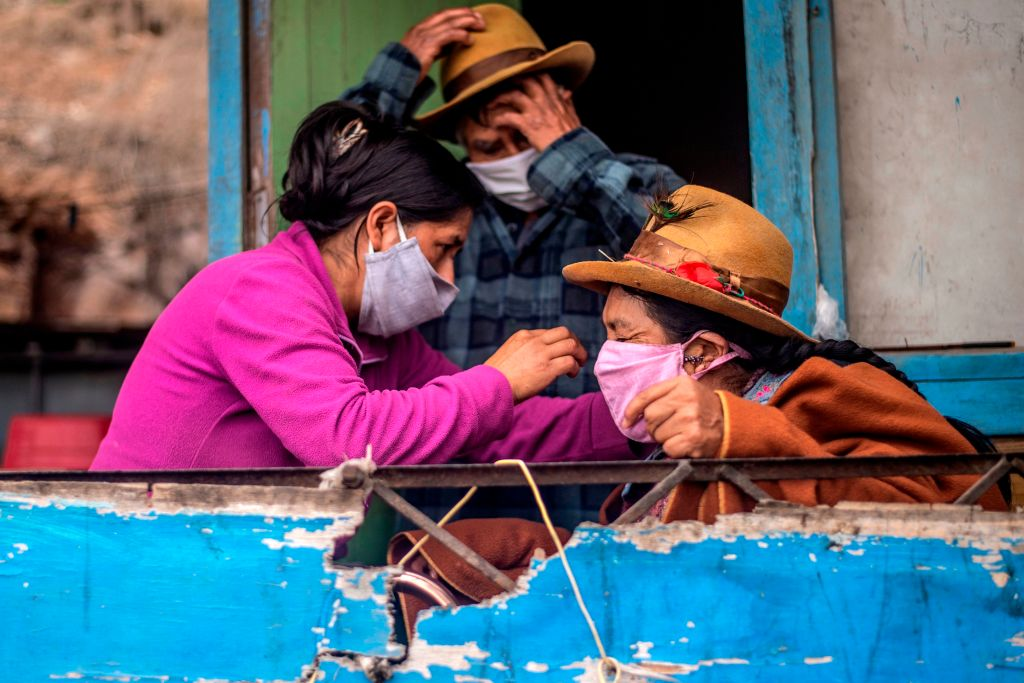

In [1]:
import os
os.environ['PYTHONHASHSEED']=str(2) #Important to set a seed for CNN
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import pickle
os.chdir('D:\\Users\\sergi\\OneDrive\\Desktop\\2022\\4. Capacitación\\6. COVID LSTM')

In [2]:
#To ensure reproducibility
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)

## Preprocessing

In [3]:
#Geting the data general and for specific country
df=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
print(np.unique(df['Country/Region']))
country='Peru'
df_country=df.loc[df['Country/Region']==country]
df_country

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Antarctica'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
215,NaN,Peru,-9.19,-75.0152,0,0,0,0,0,0,...,4486034,4486282,4484769,4486665,4486832,4486832,4486934,4486934,4487553,4487553


In [4]:
#Convert to long format
df_country_long = df_country.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], #The ones that would identify
                  var_name="Date", 
                  value_name="Cases")
df_country_long=df_country_long.iloc[:,4:] #To just have relevant information (all identifiers are constants)
df_country_long['Date']=pd.to_datetime(df_country_long["Date"], format="%m/%d/%y") #Convert to relevant format
df_country_long=df_country_long.set_index('Date') #Set as index
df_country_long=df_country_long.sort_index() #ALWAYS
df_country_long

,Cases
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2023-03-05,4486832
2023-03-06,4486934
2023-03-07,4486934


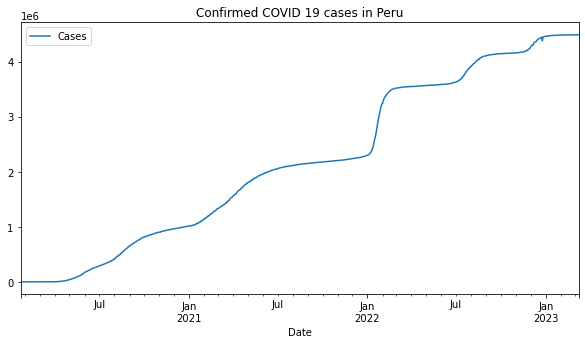

Total days 1143


In [5]:
#First exploration - The variable is accumulative (confirmed cases)
df_country_long.plot(figsize=(10,5),title='Confirmed COVID 19 cases in ' + country)
plt.show()
print('Total days '+str(len(df_country_long)))

In [6]:
# create a MinMaxScaler object
scaler = MinMaxScaler()

# normalize the Cases column
normalized_cases = scaler.fit_transform(df_country_long[['Cases']]) #Notice double brackets. We save it in a different element and the assign that element as a new column

# replace the Cases column with the normalized data
df_country_long['N_Cases'] = normalized_cases #Save it in a different column for final comparison

df_country_long2=pd.DataFrame(df_country_long['N_Cases']) #Now just use the normalized part for training

In [7]:
# OPTION2: create a MinMaxScaler object - Second option (rescaled based only in train)
x=len(df_country_long2)-15 #We want to test using the last 15 days - We can change this later
train_data2=df_country_long.iloc[:x]
test_data2=df_country_long.iloc[x:]

scaler2 = MinMaxScaler()
scaler2.fit(train_data2) 

train_scaled2 = scaler2.transform(train_data2)
test_scaled2 = scaler2.transform(test_data2) #This values would surpass 1

In [8]:
#Create test data
x=len(df_country_long2)-15 #We want to test using the last 15 days - We can change this later
train_data=df_country_long2.iloc[:x]
test_data=df_country_long2.iloc[x:]

train_data_values=train_data.values #IMPORTANT: We should keep the array format to be able to adequate the generator and LSTM model
test_data_values=test_data.values

#### Adequation of data for LSTM format

In [9]:
#For training data
from keras.preprocessing.sequence import TimeseriesGenerator #To use previous data as features
seq_size = 5  ## number of steps (lookback) - 8th day will be our Y for each date
n_features = 1 ## number of features. This dataset is univariate so it is 1 (just with dates)
train_generator = TimeseriesGenerator(train_data_values, train_data_values, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train_data_values)) 
print("Total number of samples in the generated data = ", len(train_generator)) # -x with seq_size=7 (chunks of 7 dates)

Total number of samples in the original training data =  1128
Total number of samples in the generated data =  1123


In [10]:
#For test data
from keras.preprocessing.sequence import TimeseriesGenerator #To use previous data as features
seq_size = 5  ## number of steps (lookback) - 8th day will be our Y for each date
n_features = 1 ## number of features. This dataset is univariate so it is 1 (just with dates)
test_generator = TimeseriesGenerator(test_data_values, test_data_values, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test_data_values)) 
print("Total number of samples in the generated data = ", len(test_generator)) # -x with seq_size=7 (chunks of 7 dates)

Total number of samples in the original training data =  15
Total number of samples in the generated data =  10


## LSTM Neural Networks

#### Option 1 (1st scaled)

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#I. Architecture
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features))) #We select True because in the next layer we add another LSTM layer. If that is not desired, set it to False
model.add(LSTM(64, activation='relu'))
model.add(Dense(64)) #Hyperparameter
model.add(Dense(1)) #Final outcome is just one number
#II. Compile
model.compile(optimizer='adam', loss='mean_squared_error') #Simplest loss function

In [12]:
# #Training
# # Seed
# reset_random_seeds()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,restore_best_weights=True)
# history_training1=model.fit(train_generator,
#                                      validation_data=test_generator,
#                                      epochs=50,callbacks=[es],workers=6,use_multiprocessing=True)

In [13]:
# #Save model
# model.save('model1.h5')
# #Load model
from keras.models import load_model
model=keras.models.load_model('model1.h5')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 150)            91200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                55040     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%capture
# #Save history results
# with open('saved_dictionary_model1.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_training1, f)
# #Load        
with open('saved_dictionary_model1.pkl', 'rb') as f: #Load results
    history_training1 = pickle.load(f)
history_training1=pd.DataFrame(history_training1.history)

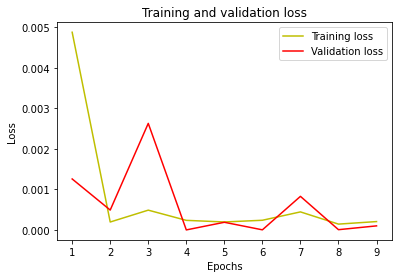

In [16]:
#plot the training and validation accuracy and loss at each epoch
loss = history_training1['loss']
val_loss = history_training1['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
#Prediction
prediction=[]

current_batch=train_data_values[-seq_size:] #Select the last 7 elements (counting from the bottom) - Final 7 points in train
# current_batch2=train_data_values[:-seq_size] #Select all the elements up to the last 7
current_batch=current_batch.reshape(1,seq_size,n_features)#Reshaped - This is our input to predict future

In [18]:
#Predict future (even beyond test data)
future=5
for i in range(len(test_data_values)+future):
    current_prediction=model.predict(current_batch)[0]
    prediction.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:],[[current_prediction]],axis=1) #Why we not use i: this line updates the current_batch by shifting it one time step forward and replacing the last element with the current prediction.

1/1 [==============================] - 0s 17ms/step


In [19]:
#We already have the predictions, but they are not easy to interpret since the are normalized
rescaled_results=scaler.inverse_transform(prediction) #Reinverse transform
test_data['N_Cases2']=scaler.inverse_transform(test_data[['N_Cases']])
print(prediction)
print(rescaled_results)

[array([0.99959666], dtype=float32), array([0.9996328], dtype=float32), array([0.99968326], dtype=float32), array([0.9997405], dtype=float32), array([0.99980724], dtype=float32), array([0.9998967], dtype=float32), array([0.9999529], dtype=float32), array([1.0000156], dtype=float32), array([1.0000818], dtype=float32), array([1.0001501], dtype=float32), array([1.0002183], dtype=float32), array([1.0002813], dtype=float32), array([1.0003463], dtype=float32), array([1.000412], dtype=float32), array([1.0004777], dtype=float32), array([1.0005425], dtype=float32), array([1.0006065], dtype=float32), array([1.0006713], dtype=float32), array([1.0007354], dtype=float32), array([1.0007995], dtype=float32)]
[[4485742.96959025]
 [4485905.06186575]
 [4486131.61658084]
 [4486388.39642322]
 [4486687.97290599]
 [4487089.45888871]
 [4487341.69158804]
 [4487623.07949865]
 [4487919.9811914 ]
 [4488226.51212823]
 [4488532.50810707]
 [4488815.50089169]
 [4489107.05300438]
 [4489401.81486511]
 [4489696.5767258

C:\Users\sergi\AppData\Local\Temp\ipykernel_30036\3972904000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['N_Cases2']=scaler.inverse_transform(test_data[['N_Cases']])


In [20]:
#To interpret easily lets convert everything into a dataframe
time_series_array=test_data.index
#Add new dates for the forecast period - Not originally in the dataframe
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

In [21]:
pd.options.display.float_format = '{:.6f}'.format
df_forecast.loc[:,"predicted"] = rescaled_results[:,0]
df_forecast.loc[:,"actual_confirmed"] = test_data["N_Cases2"]
df_forecast=df_forecast.round()

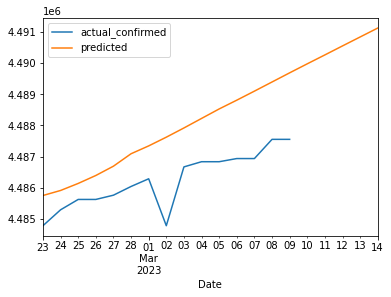

In [22]:
ax=df_forecast.plot()
plt.show()

#### Option 2 (2nd scaled)

In [23]:
#I. Architecture
model2 = Sequential()
model2.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features))) #We select True because in the next layer we add another LSTM layer. If that is not desired, set it to False
model2.add(LSTM(64, activation='relu'))
model2.add(Dense(64)) #Hyperparameter
model2.add(Dense(1)) #Final outcome is just one number
#II. Compile
model2.compile(optimizer='adam', loss='mean_squared_error') #Simplest loss function

In [24]:
#OPTION 2: For training data (different scaled)
from keras.preprocessing.sequence import TimeseriesGenerator #To use previous data as features
seq_size = 5  ## number of steps (lookback) - 8th day will be our Y for each date
n_features = 1 ## number of features. This dataset is univariate so it is 1 (just with dates)
train_scaled2=train_scaled2[:,1]
train_scaled2=train_scaled2.reshape(-1, 1)
train_generator2 = TimeseriesGenerator(train_scaled2, train_scaled2, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train_scaled2)) 
print("Total number of samples in the generated data = ", len(train_generator2)) # -x with seq_size=7 (chunks of 7 dates)

Total number of samples in the original training data =  1128
Total number of samples in the generated data =  1123


In [25]:
#OPTION 2: For test data (different scaled)
from keras.preprocessing.sequence import TimeseriesGenerator #To use previous data as features
seq_size = 5  ## number of steps (lookback) - 8th day will be our Y for each date
n_features = 1 ## number of features. This dataset is univariate so it is 1 (just with dates)
test_scaled2=test_scaled2[:,1]
test_scaled2=test_scaled2.reshape(-1, 1)
test_generator2 = TimeseriesGenerator(test_scaled2, test_scaled2, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test_scaled2)) 
print("Total number of samples in the generated data = ", len(test_generator2)) # -x with seq_size=7 (chunks of 7 dates)

Total number of samples in the original training data =  15
Total number of samples in the generated data =  10


In [26]:
#Training
# # Seed
# reset_random_seeds()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,restore_best_weights=True)
# history_training2=model2.fit(train_generator2,
#                                      validation_data=test_generator2,
#                                      epochs=50,callbacks=[es],workers=6,use_multiprocessing=True)

In [27]:
# # #Save model
# model2.save('model2.h5')
# #Load model
from keras.models import load_model
model2=keras.models.load_model('model2.h5')

In [28]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 150)            91200     
                                                                 
 lstm_3 (LSTM)               (None, 64)                55040     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%capture
# #Save history results
# with open('saved_dictionary_model2.pkl', 'wb') as f: #Save history results
#      pickle.dump(history_training2, f)
#Load        
with open('saved_dictionary_model2.pkl', 'rb') as f: #Load results
    history_training2 = pickle.load(f)
history_training2=pd.DataFrame(history_training2.history)

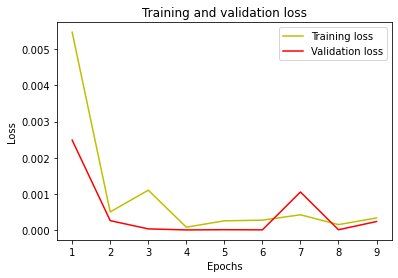

In [30]:
#plot the training and validation accuracy and loss at each epoch
loss = history_training2['loss']
val_loss = history_training2['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
#Prediction
prediction=[]

current_batch=train_data_values[-seq_size:] #Select the last 7 elements (counting from the bottom) - Final 7 points in train
# current_batch2=train_data_values[:-seq_size] #Select all the elements up to the last 7
current_batch=current_batch.reshape(1,seq_size,n_features)#Reshaped - This is our input to predict future

In [32]:
#Predict future (even beyond test data)
future=5
for i in range(len(test_data_values)+future):
    current_prediction=model2.predict(current_batch)[0]
    prediction.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:],[[current_prediction]],axis=1) #Why we not use i: this line updates the current_batch by shifting it one time step forward and replacing the last element with the current prediction.

1/1 [==============================] - 0s 17ms/step


In [33]:
#We already have the predictions, but they are not easy to interpret since the are normalized
rescaled_results=scaler.inverse_transform(prediction) #Reinverse transform
test_data['N_Cases2']=scaler.inverse_transform(test_data[['N_Cases']])
print(prediction)
print(rescaled_results)

[array([1.0000838], dtype=float32), array([1.0001729], dtype=float32), array([1.0003124], dtype=float32), array([1.0004913], dtype=float32), array([1.000716], dtype=float32), array([1.0009985], dtype=float32), array([1.0011634], dtype=float32), array([1.0013562], dtype=float32), array([1.0015651], dtype=float32), array([1.001781], dtype=float32), array([1.0019925], dtype=float32), array([1.0021856], dtype=float32), array([1.002388], dtype=float32), array([1.0025929], dtype=float32), array([1.0027968], dtype=float32), array([1.0029974], dtype=float32), array([1.0031956], dtype=float32), array([1.0033959], dtype=float32), array([1.0035951], dtype=float32), array([1.0037934], dtype=float32)]
[[4487929.07547748]
 [4488328.68910718]
 [4488955.12493098]
 [4489757.56193841]
 [4490765.95777774]
 [4492033.80824947]
 [4492773.65517032]
 [4493639.21722233]
 [4494576.46364701]
 [4495545.27259398]
 [4496494.28809476]
 [4497360.92006278]
 [4498269.27875519]
 [4499188.8715657 ]
 [4500103.64975417]
 [

C:\Users\sergi\AppData\Local\Temp\ipykernel_30036\3972904000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['N_Cases2']=scaler.inverse_transform(test_data[['N_Cases']])


In [34]:
#To interpret easily lets convert everything into a dataframe
time_series_array=test_data.index
#Add new dates for the forecast period - Not originally in the dataframe
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

In [35]:
pd.options.display.float_format = '{:.6f}'.format
df_forecast.loc[:,"predicted"] = rescaled_results[:,0]
df_forecast.loc[:,"actual_confirmed"] = test_data["N_Cases2"]
df_forecast=df_forecast.round()

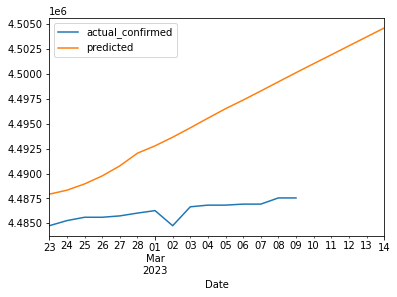

In [36]:
ax=df_forecast.plot()
plt.show()